In [155]:
from avaframe.in2Trans.rasterUtils import readRaster
from pathlib import Path
import os
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.patches import Polygon
import json
import numpy as np
import hashlib
import subprocess

from matplotlib.path import Path as mplPath
from matplotlib.colors import ListedColormap
from avaframe.in2Trans.shpConversion import SHP2Array
from matplotlib import colors
import pandas as pd
import pickle

from com1DFAUtils import *

%load_ext autoreload
%autoreload 2

sim_case = "avaParabola"
friction_model = "samosat"
avaframe_dir = Path(r"C:\git\snow_avalanches\AvaFrame\avaframe")
avaframe_data_dir = avaframe_dir / ("data" + friction_model)

eval_app = Path(r"C:\git\webigeo\cmake-build-release-visual-studio") / "webigeo_eval.exe"

webigeo_input_dir = Path.cwd() / "webigeo_input" / friction_model
webigeo_output_dir = Path.cwd() / "webigeo_output" / friction_model
webigeo_sim_dir = webigeo_output_dir / sim_case
sim_case_dir = avaframe_data_dir / sim_case
avaframe_input_dir = sim_case_dir / "Inputs"
avaframe_output_dir = sim_case_dir / "Outputs" / "com1DFA"
webigeo_to_avaframe_output_dir = sim_case_dir / "Outputs" / "webigeo"
avaframe_output_peak_dir = avaframe_output_dir / "peakFiles"
release_path = avaframe_input_dir / "REL"
release_scenerios = [file.replace(".shp", "") for file in os.listdir(release_path) if file.endswith(".shp")]
print("Release scenarios:", release_scenerios)



dem_header, dem = get_dem(avaframe_input_dir)
y = np.arange(0, dem_header["nrows"] * dem_header["cellsize"],  dem_header["cellsize"]) + dem_header["yllcenter"]
x = np.arange(0, dem_header["ncols"] * dem_header["cellsize"],  dem_header["cellsize"]) + dem_header["xllcenter"]
xx, yy = np.meshgrid(x, y)

    
# np.nan_to_num

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Release scenarios: ['release1PF']


In [158]:
release_areas = get_release_areas(release_path / release_scenerios[0])
print("Release areas:", release_areas)
for ra in release_areas:
    path = ra.get_path()
    vertices = path.vertices

    for v in vertices:
        v[0] -= dem_header['xllcenter']
        v[1] -= dem_header['yllcenter']
        print(v)
    # Calculate the centroid
    centroid_x = np.mean(vertices[:, 0])  # Average of x-coordinates
    centroid_y = np.mean(vertices[:, 1])  # Average of y-coordinates
    # centroid = (centroid_x - dem_header['xllcenter'], centroid_y - dem_header['yllcenter'])
    print("Centroid:", centroid_x, centroid_y)
# plot_inputs(xx, yy, dem, release_areas)

No projection layer for shp file C:\git\snow_avalanches\AvaFrame\avaframe\datasamosat\avaParabola\Inputs\REL\release1PF


Release areas: [<matplotlib.patches.Polygon object at 0x0000027F072C6F50>]
[1519.31472837  875.        ]
[1519.31472837 1125.        ]
[1865.72488989 1125.        ]
[1865.72488989  875.        ]
[1519.31472837  875.        ]
Centroid: 1657.8787929779999 975.0


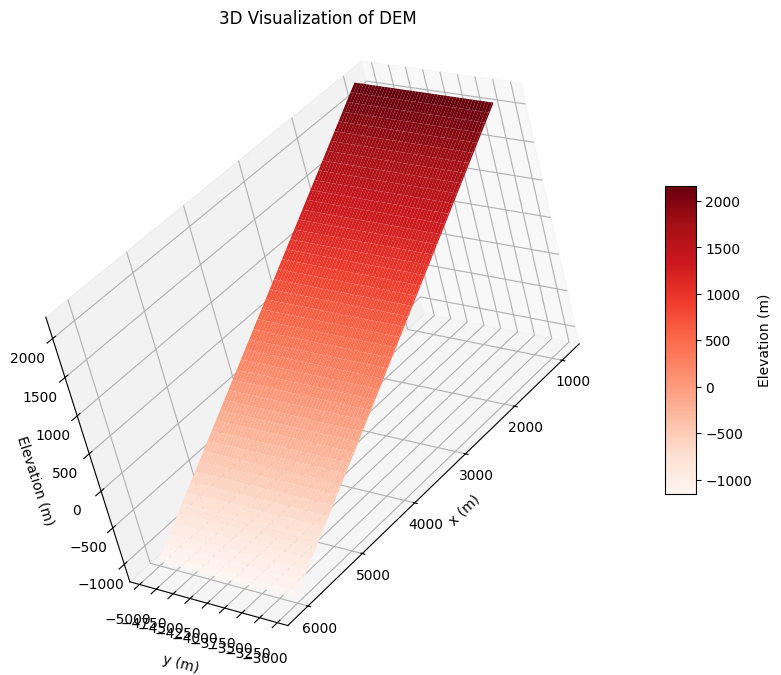

In [59]:
fig, ax = plot_dem_3d(xx, yy, dem)
ax.view_init(elev=30, azim=45, roll=15)

In [156]:
files = [file for file in os.listdir(avaframe_output_peak_dir) if file.endswith("pfv.asc") if file.find("null") != -1 if file.find("webigeo") == -1]
print(avaframe_output_dir)
print(files)
flow_velocity_file = avaframe_output_peak_dir / files[0]
dfa_flow_velocity = np.zeros_like(dem)
flow_velocity = readRaster(flow_velocity_file, noDataToNan=True)
flow_velocity_header = flow_velocity["header"]
flow_velocity = flow_velocity["rasterData"]
dfa_flow_velocity[:flow_velocity.shape[0], :flow_velocity.shape[1]] = flow_velocity

C:\git\snow_avalanches\AvaFrame\avaframe\datasamosat\avaParabola\Outputs\com1DFA
['release1PF_c377c0b167_C_M_null_dfa_pfv.asc']


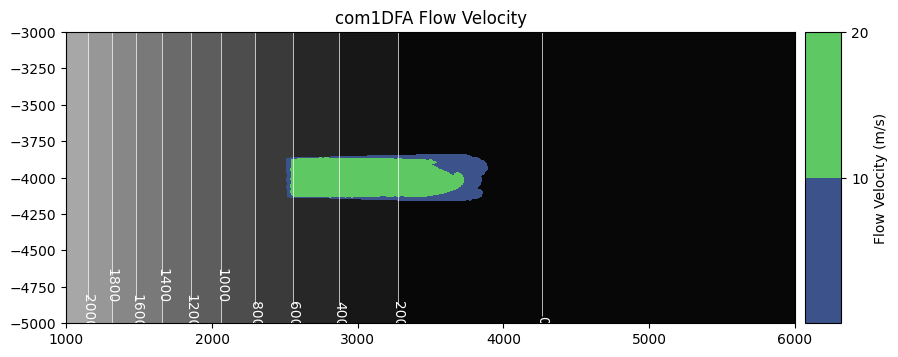

In [157]:

plot_flow_velocity(dfa_flow_velocity, dem, xx, yy, title="com1DFA Flow Velocity");

In [148]:
# prepare webigeo simulation
for release_scenerio in release_scenerios:
    pattern = webigeo_input_dir / sim_case / release_scenerio / "*.json"

    # Use glob to find all matching files
    for file in Path(pattern.parent).glob(pattern.name):
        print(f"Removing file: {file}")
        os.remove(file)
    release_areas = get_release_areas(release_path / (release_scenerio + ".shp"))
    input_path =  webigeo_input_dir / sim_case / release_scenerio
    webigeo_export_release_points_path = input_path / "release_points"
    webigeo_export_dem_path = input_path / "heights"
    os.makedirs(input_path, exist_ok=True)
    os.makedirs(webigeo_export_release_points_path, exist_ok=True)
    os.makedirs(webigeo_export_dem_path, exist_ok=True)
    export_webigeo_release_points(webigeo_export_release_points_path, xx, yy, release_areas)
    corrected_dem = dem_np_to_webigeo(webigeo_export_dem_path, dem_header, dem)
    settings = export_webigeo_settings(input_path, webigeo_output_dir / sim_case / release_scenerio, 
                                    random_contribution=0.5, 
                                    persistence=0.9, 
                                    num_paths_per_release_cell=2, 
                                    num_steps=5000,
                                    model=1, friction_model=friction_model.lower())
    print("Exported webigeo settings to", input_path)

No projection layer for shp file C:\git\snow_avalanches\AvaFrame\avaframe\datavoellmy\avaInclinedPlane\Inputs\REL\release1IP.shp


Removing file: c:\git\evaluation-utilities\webigeo_input\voellmy\avaInclinedPlane\release1IP\settings_522e3e_fricmodel_voellmy_mu_0.155_cd_4000_rho_200_h_0.5_n_2_s_5000_a_25.json
DEM: (401, 1001) 401401
Release pixels: 3245
Exported webigeo settings to c:\git\evaluation-utilities\webigeo_input\voellmy\avaInclinedPlane\release1IP


Running Webigeo in:  c:\git\evaluation-utilities\webigeo_input\voellmy\avaInclinedPlane\release1IP
Running Webigeo with settings file:  c:\git\evaluation-utilities\webigeo_input\voellmy\avaInclinedPlane\release1IP\settings_522e3e_fricmodel_voellmy_mu_0.155_cd_4000_rho_200_h_0.5_n_2_s_5000_a_25.json
Running Webigeo app:  C:\git\webigeo\cmake-build-release-visual-studio\webigeo_eval.exe
Return Code: 0
Save to: c:\git\evaluation-utilities\webigeo_input\voellmy\avaInclinedPlane\release1IP
Plot: c:\git\evaluation-utilities\webigeo_output\voellmy\avaInclinedPlane\release1IP\522e3e_fricmodel_voellmy_mu_0.155_cd_4000_rho_200_h_0.5_n_2_s_5000_a_25\trajectories\texture_layer1_zdelta.png


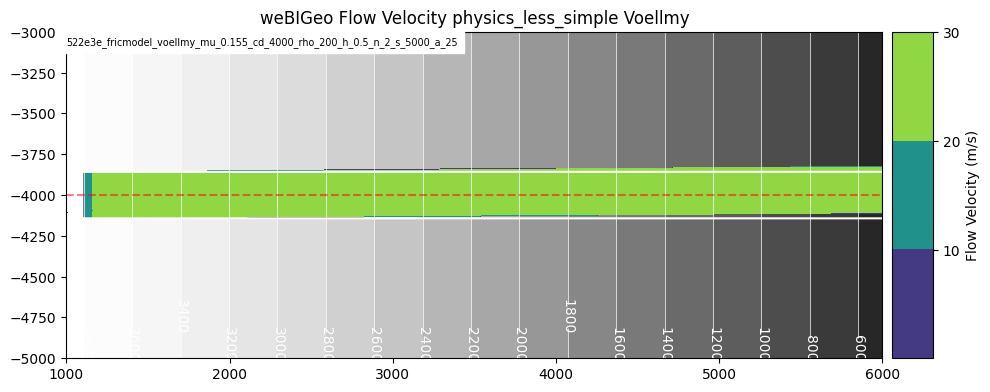

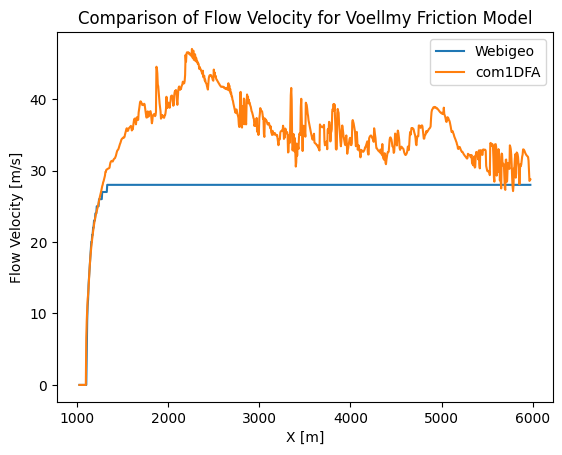

In [151]:
# run all simulations

# eval_app = Path(r"C:\git\webigeo\cmake-build-debug-visual-studio") / "webigeo_eval.exe"
eval_app = Path(r"C:\git\webigeo\cmake-build-release-visual-studio") / "webigeo_eval.exe"
import subprocess
for release_scenerio in os.listdir(webigeo_input_dir / sim_case):
    sim_dir = webigeo_input_dir / sim_case / release_scenerio
    for file in os.listdir(sim_dir):
        if file.startswith("settings") and file.endswith(".json"):
            settings_file = webigeo_input_dir / sim_case / release_scenerio / file
            print("Running Webigeo in: ", webigeo_input_dir / sim_case / release_scenerio)
            print("Running Webigeo with settings file: ", settings_file)
            print("Running Webigeo app: ", eval_app)
            result = subprocess.run([eval_app, settings_file], capture_output=True, text=True)

            # Print the output
            if "Error while parsing WGSL" in result.stdout:
                print("STDOUT:")
                print(result.stdout)

            print("Return Code:", result.returncode)

            plot_dir = sim_dir / "plots"
            os.makedirs(plot_dir, exist_ok=True)

            settings = json.load(open(sim_dir / file))
            print(f"Save to: {sim_dir}")
            identifier = file.replace(".json", "").replace("settings_", "")
            png_filename = webigeo_output_dir / sim_case / release_scenerio / identifier / r"trajectories\texture_layer1_zdelta.png"
            print(f"Plot: {png_filename}")
            velocity = read_webigeo_flow_velocity(png_filename)
            # velocity[velocity > 100] = np.nan
            
            fig, ax = plot_flow_velocity(velocity, corrected_dem, xx, yy, title=f"weBIGeo Flow Velocity physics_less_simple {friction_model.title()}")
            ax.contour(xx, yy, dfa_flow_velocity > 0, colors="white", alpha=1)
            ax.text(0, .96, identifier, size="x-small", backgroundcolor="white", color="black", transform=ax.transAxes)
            ax.axhline(-4000, color="red", linestyle="--", alpha=0.5)
            fig.tight_layout()
            fig.savefig(plot_dir / f"{identifier}_flow_velocity.png", dpi=300)

            # fig, ax = plot_flow_velocity_diff(velocity, np.where((velocity > 1) & (dfa_flow_velocity > 1), dfa_flow_velocity, np.nan), corrected_dem, xx, yy)
            # fig.savefig(plot_dir / f"{sim_case}_flow_velocity_diff.png", dpi=300)

            if sim_case == "avaInclinedPlane":
                offset = 5
                y_plane = int(dem.shape[0]/2)
                fig, ax = plt.subplots()
                ax.plot(xx[0,offset:-offset], velocity[y_plane,offset:-offset])
                ax.plot(xx[0,offset:-offset], dfa_flow_velocity[y_plane,offset:-offset])
                ax.set(xlabel="X [m]", ylabel="Flow Velocity [m/s]", title=f"Comparison of Flow Velocity for {friction_model.title()} Friction Model")
                ax.legend(["Webigeo", "com1DFA"])
                fig.savefig(plot_dir / f"{identifier}_flow_comparison.png", dpi=300)

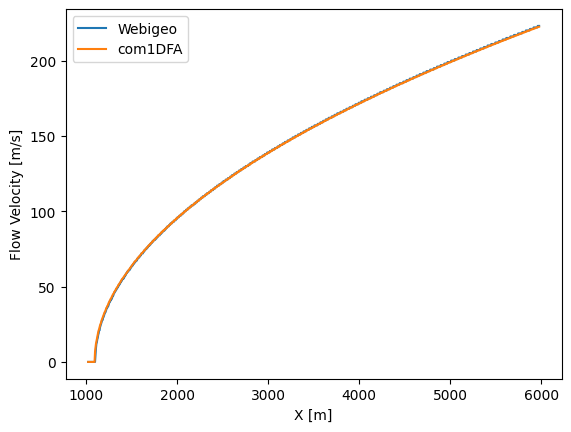

In [64]:
offset = 5
y_plane = int(dem.shape[0]/2)
plt.plot(xx[0,offset:-offset], velocity[y_plane,offset:-offset])
plt.plot(xx[0,offset:-offset], dfa_flow_velocity[y_plane,offset:-offset])
plt.xlabel("X [m]")
plt.ylabel("Flow Velocity [m/s]")
plt.legend(["Webigeo", "com1DFA"])


c:\git\evaluation-utilities\webigeo_output\dfa\avaHelixChannel\release1HX\090823_pers_0.90_rand_0.50_n_256_s_2000_a_25
c:\git\evaluation-utilities\webigeo_output\dfa\avaHelixChannel\release1HX\9096a0_pers_0.90_rand_0.50_n_256_s_3000_a_25
c:\git\evaluation-utilities\webigeo_output\dfa\avaHelixChannel\release1HX\cf461c_pers_0.90_rand_0.50_n_256_s_4000_a_25
c:\git\evaluation-utilities\webigeo_output\dfa\avaHelixChannel\release1HX\d6979d_pers_0.90_rand_0.50_n_256_s_5000_a_25


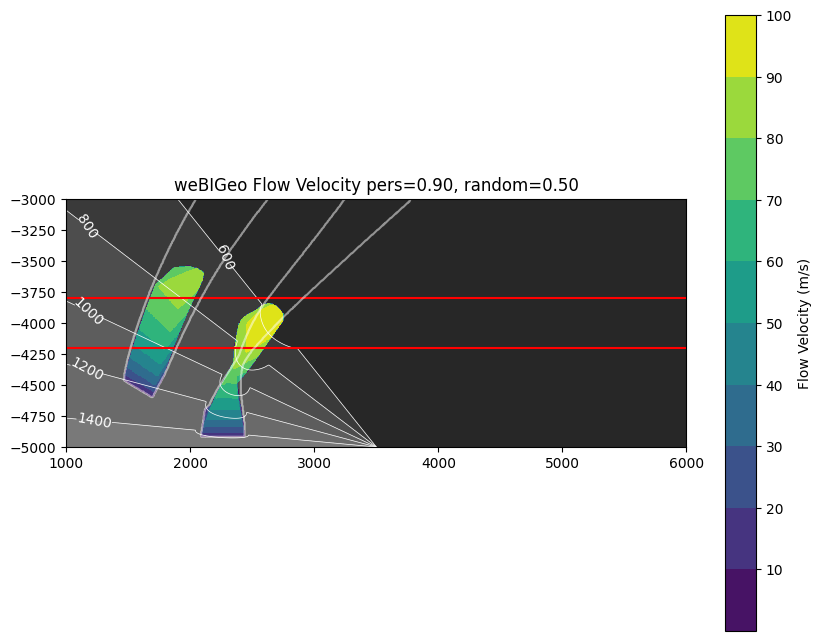

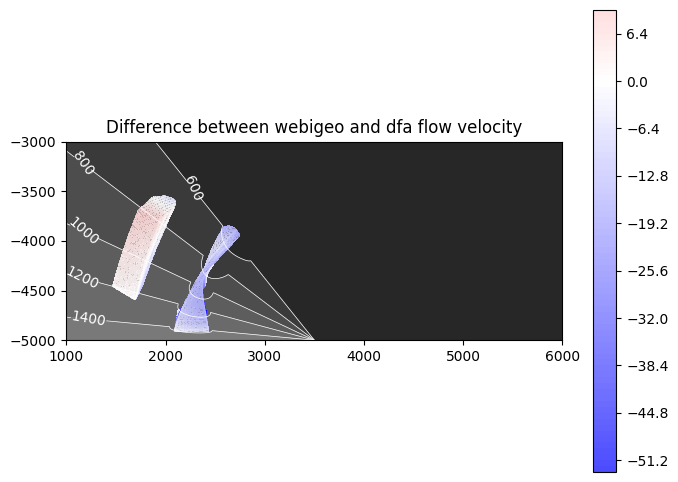

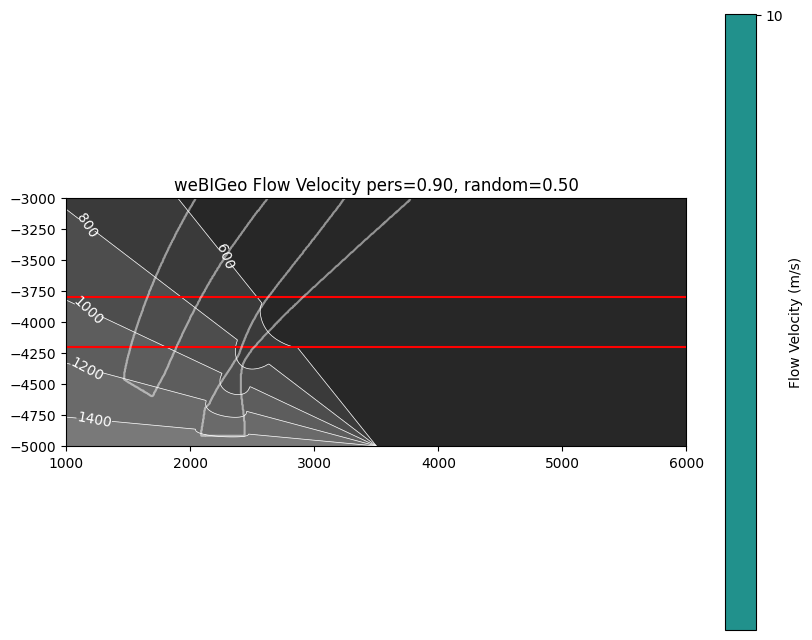

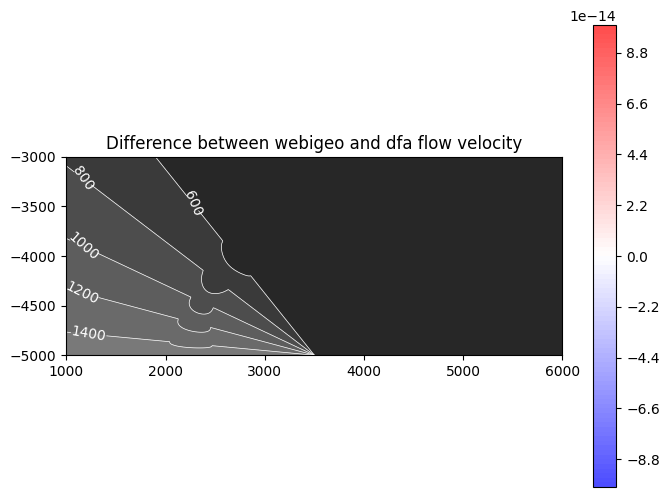

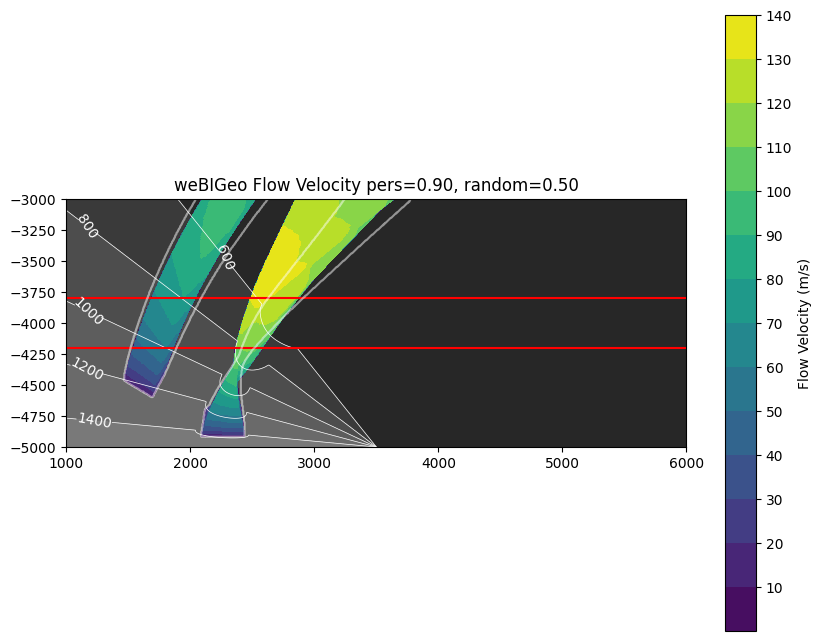

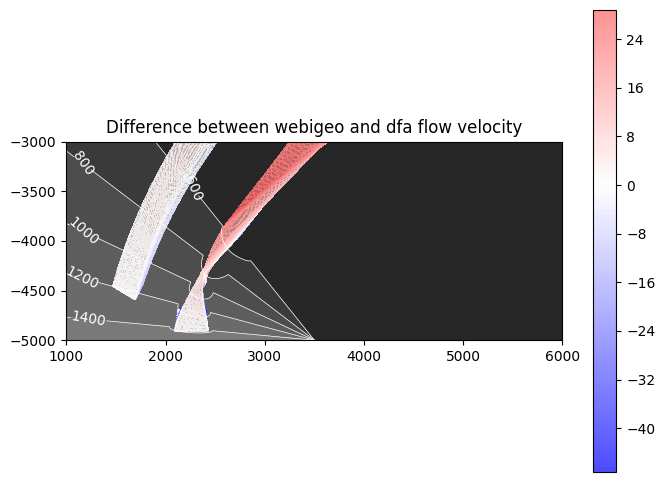

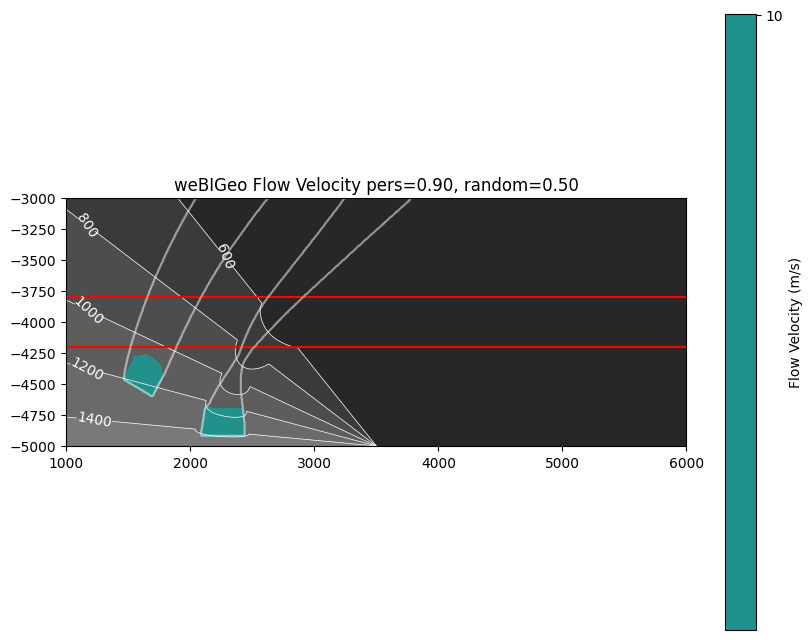

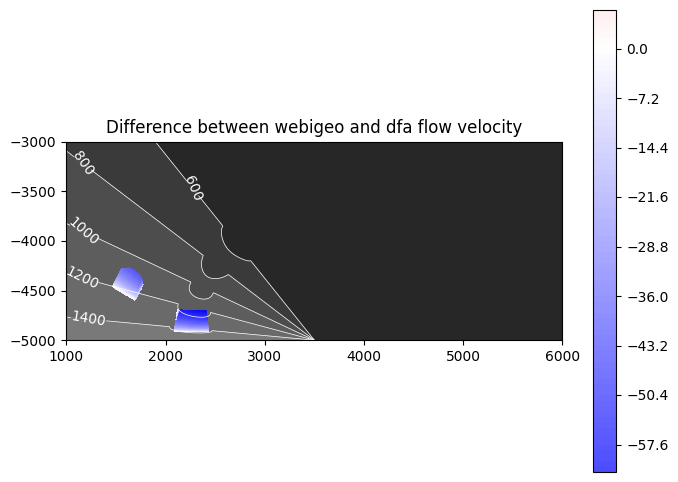

In [ ]:
for release_scenerio in release_scenerios:
    d = webigeo_output_dir / sim_case / release_scenerio
    sim_cases = [dd for dd in os.listdir(d) if os.path.isdir(d / dd) and dd != "plots"]
    shifted_dem_mask = np.ones_like(corrected_dem, dtype=bool)
    shifted_dem_mask_left = np.ones_like(corrected_dem, dtype=bool)
    shifted_dem_mask_right = np.ones_like(corrected_dem, dtype=bool)
    edge_distance = 3
    shifted_dem_mask_left[:, :-edge_distance] = np.isnan(corrected_dem)[:, edge_distance:]
    shifted_dem_mask_right[:, edge_distance:] = np.isnan(corrected_dem)[:, :-edge_distance]
    shifted_dem_mask = shifted_dem_mask_left | shifted_dem_mask_right

    for case in sim_cases:
            print(d / case)
            plot_dir = d /case / "plots"

            settings = json.load(open(d / case / "settings.json"))
            png_filename = d / case / r"trajectories\texture_layer1_zdelta.png"
            velocity = read_webigeo_flow_velocity(png_filename)
            # velocity[shifted_dem_mask] = 0
            # velocity[velocity > 100] = np.nan
            fig, ax = plot_flow_velocity(velocity, corrected_dem, xx, yy, title=f"weBIGeo Flow Velocity pers={settings['persistence_contribution']:.2f}, random={settings['random_contribution']:.2f}");

            # ax.axhline(y=-3800, color="red")
            # ax.axhline(y=-4200, color="red")
            ax.contour(xx, yy, dfa_flow_velocity > 0, colors="white", alpha=0.5)
            os.makedirs(plot_dir, exist_ok=True)
            fig.savefig(plot_dir / f"{case}_flow_velocity.png", dpi=300)
            fig, ax = plot_flow_velocity_diff(velocity, np.where((velocity > 1) & (dfa_flow_velocity > 1), dfa_flow_velocity, np.nan), corrected_dem, xx, yy)
            fig.savefig(plot_dir / f"{case}_flow_velocity_diff.png", dpi=300)

In [ ]:

try:
    os.symlink(input_path, settings["output_dir_path"], target_is_directory=True)
except FileExistsError:
    pass
try: 
    os.symlink(settings["output_dir_path"], input_path, target_is_directory=True)
except FileExistsError:

    pass

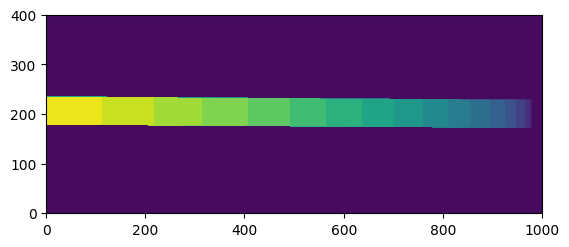

In [157]:
fig, ax = plt.subplots()
ax.contourf(velocity, levels=20)
ax.set_aspect("equal")